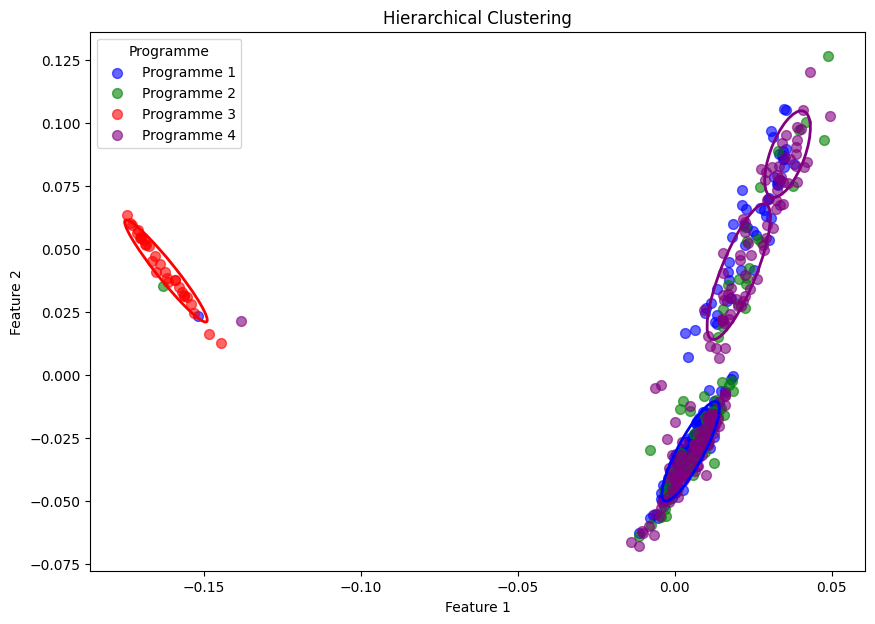

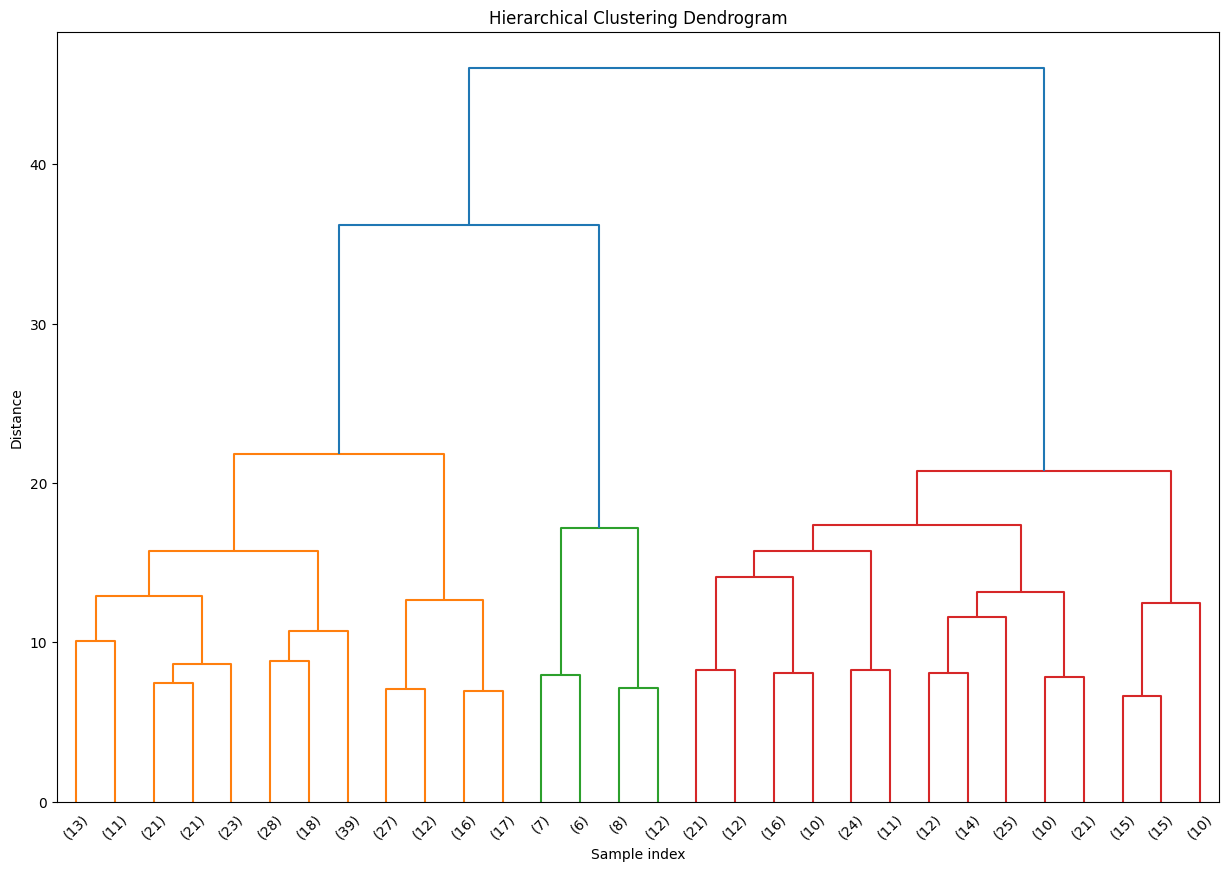

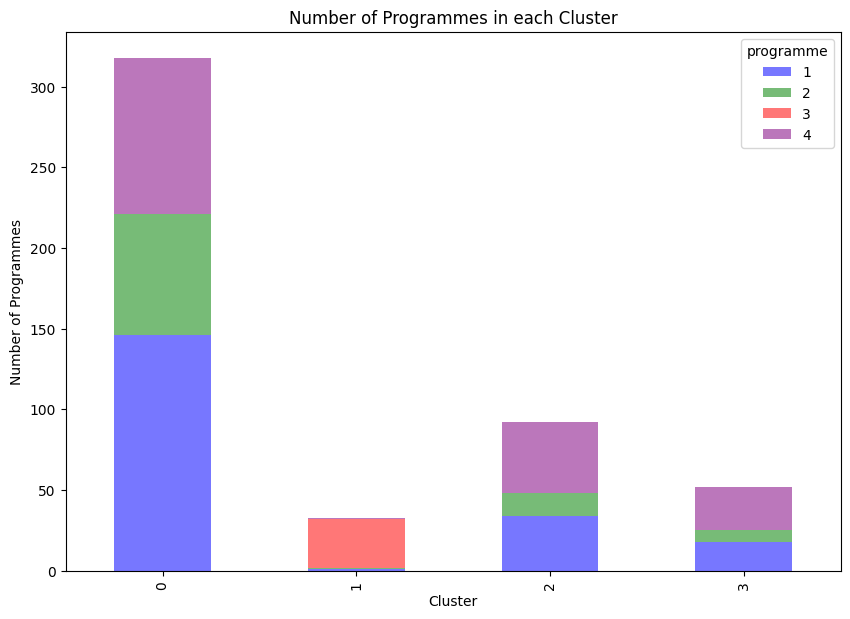

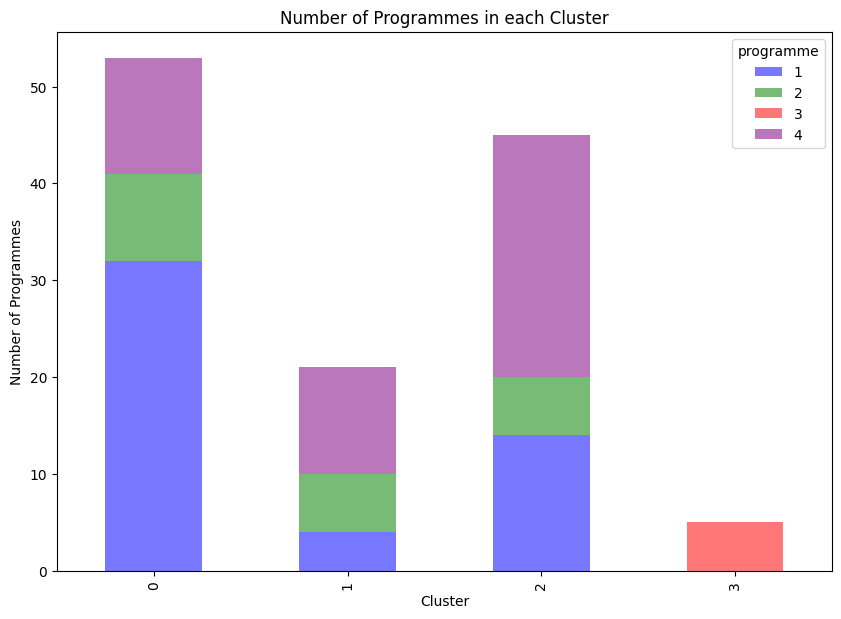

Silhouette Score: 0.698720132570687
Davies-Bouldin Index: 0.4138982723636794


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

def load_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    return data, programme

def preprocess_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

def apply_lle(data, n_components=2, n_neighbors=10, random_state=42):
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state, method='standard')
    return lle.fit_transform(data)

def apply_hierarchical_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = clustering.fit_predict(data)
    return labels, clustering
def plot_results_with_ellipses(data_isomap, labels, programme, title):
    cmap = ListedColormap(['blue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 7))
    color_map = {1: 'blue', 2: 'green', 3: 'red', 4: 'purple'}
    class_labels = ['Programme 1', 'Programme 2', 'Programme 3', 'Programme 4']

    # Scatter plot
    for i, color in zip(range(1, 5), ['blue', 'green', 'red', 'purple']):
        idx = programme == i
        plt.scatter(data_isomap[idx, 0], data_isomap[idx, 1], color=color, s=50, alpha=0.6, label=class_labels[i-1])

    plt.legend(title='Programme')
    plt.title(title)
    plt.xlabel('Feature 1')  # Adjust label as per your feature
    plt.ylabel('Feature 2')  # Adjust label as per your feature

    # Draw ellipses
    for label in np.unique(labels):
        cluster_points = data_isomap[labels == label]
        programme_cluster = programme[labels == label]
        if cluster_points.size == 0:
            continue

        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:, 0]
        theta = np.degrees(np.arctan2(vy, vx))
        width, height = 3 * np.sqrt(eigenvalues)  # 3 standard deviations to make ellipses larger

        # Determine the color by voting
        unique, counts = np.unique(programme_cluster, return_counts=True)
        most_frequent = unique[np.argmax(counts)]
        ellipse_color = color_map[most_frequent]

        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=ellipse_color, lw=2, facecolor='none')
        plt.gca().add_patch(ellipse)

    plt.show()

def plot_dendrogram(data, title):
    linked = linkage(data, 'ward')
    plt.figure(figsize=(15, 10))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, truncate_mode='lastp', p=30)
    plt.title(title)
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

def compute_cluster_programme_counts(data, labels, programme):
    df = pd.DataFrame({
        'labels': labels,
        'programme': programme
    })
    return pd.crosstab(df['labels'], df['programme'])

def optimize_hyperparameters(data):
    best_score = float('inf')  # 使用轮廓系数，初始化为无穷大，因为我们希望找到最小的DB指数
    best_params = {}
    n_clusters = 4  # 固定聚类数为4

    # 定义链接和亲和力选项
    linkages = ['ward', 'complete', 'average', 'single']
    affinities = ['euclidean', 'manhattan', 'cosine']

    for linkage in linkages:
        if linkage == 'ward':
            # 'ward' 链接方法只与 'euclidean' 亲和力兼容
            clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity='euclidean')
            labels = clustering.fit_predict(data)
            score = silhouette_score(data, labels)
            if score < best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage, 'affinity': 'euclidean'}
        else:
            for affinity in affinities:
                clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
                labels = clustering.fit_predict(data)
                score = silhouette_score(data, labels)
                if score < best_score:
                    best_score = score
                    best_params = {'n_clusters': n_clusters, 'linkage': linkage, 'affinity': affinity}

    return best_params, best_score


def plot_cluster_programme_bar(cluster_counts):
    colors = ['#0000FF88', '#00800088', '#FF000088', '#80008088']  # 颜色代码，包括透明度
    ax = cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 7), color=colors)
    plt.title('Number of Programmes in each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Programmes')
    plt.xticks(rotation=90)
    plt.show()




def main():
    file_path = 'CW_Data.xlsx'
    data, programme = load_data(file_path)
    data_scaled = preprocess_data(data)
    train_data, test_data, train_programme, test_programme = train_test_split(data_scaled, programme, test_size=0.20, random_state=42)

    # 对训练集和测试集应用 Isomap
    train_pca = apply_lle(train_data)
    test_pca = apply_lle(test_data)  # 这是修复的部分

    # 对训练集应用层次聚类
    train_labels, clustering = apply_hierarchical_clustering(train_pca, n_clusters=4)
    # 对测试集应用层次聚类
    test_labels, _ = apply_hierarchical_clustering(test_pca, n_clusters=4)  # 确保也为测试集进行聚类

    # 绘制训练集的聚类结果和树状图
    plot_results_with_ellipses(train_pca, train_labels, train_programme, 'Hierarchical Clustering')
    plot_dendrogram(train_data, 'Hierarchical Clustering Dendrogram')

    # 计算评估指标
    sil_score = silhouette_score(train_pca, train_labels)
    db_score = davies_bouldin_score(train_pca, train_labels)

    # 计算并绘制训练集中每个聚类的programme数量
    train_cluster_counts = compute_cluster_programme_counts(train_pca, train_labels, train_programme)
    plot_cluster_programme_bar(train_cluster_counts)
    
    # 计算并绘制测试集中每个聚类的programme数量
    test_cluster_counts = compute_cluster_programme_counts(test_pca, test_labels, test_programme)
    plot_cluster_programme_bar(test_cluster_counts)

    print(f'Silhouette Score: {sil_score}')
    print(f'Davies-Bouldin Index: {db_score}')

if __name__ == "__main__":
    main()



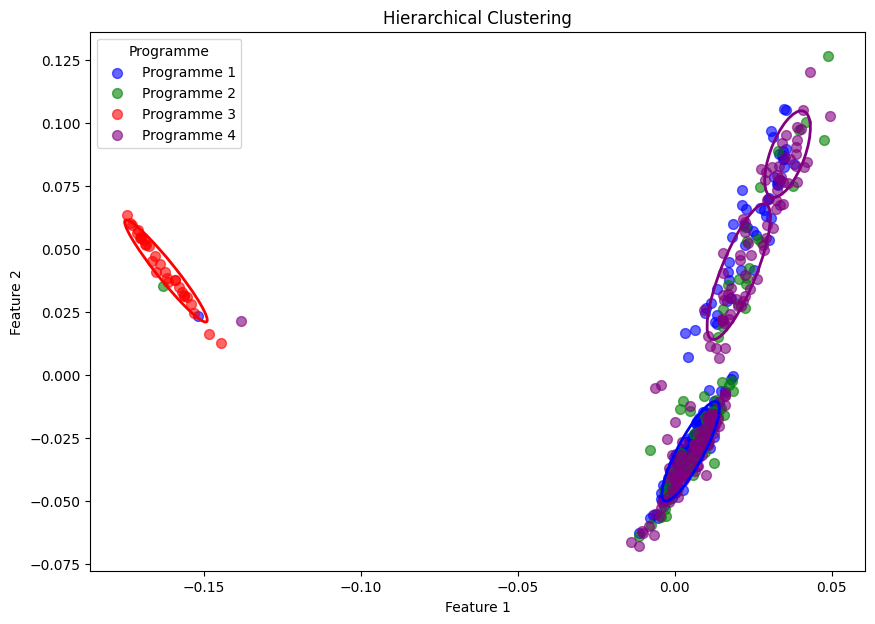

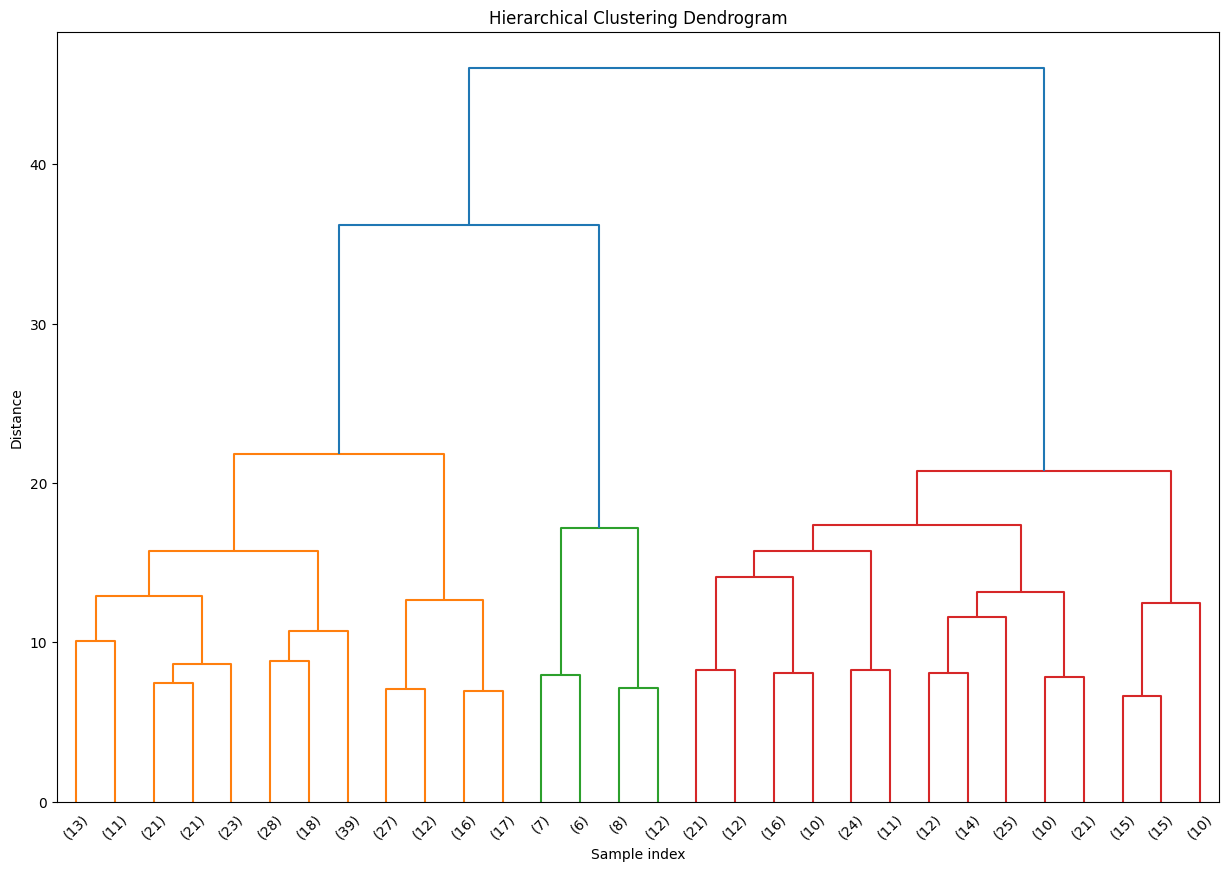

NameError: name 'train_lle' is not defined

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, programme

def apply_lle(data, n_components=2, n_neighbors=10, random_state=42):
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state, method='standard')
    return lle.fit_transform(data)

def optimize_kmeans(data, programme, n_clusters_range=[4, 5, 6, 7, 8, 9], random_state=42):
    best_score = -1
    best_kmeans = None
    best_params = None

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        labels = kmeans.fit_predict(data)
        score = adjusted_rand_score(programme, labels)
        if score > best_score:
            best_score = score
            best_kmeans = kmeans
            best_params = {'n_clusters': n_clusters}
            print(f"New best K-means found: n_clusters={n_clusters}, ARI Score={score}")

    if best_params:
        print(f'Overall Best K-means: n_clusters={best_params["n_clusters"]}, ARI Score={best_score}')
    return best_kmeans, best_params

def plot_results_with_ellipses(data_isomap, labels, programme, title):
    cmap = ListedColormap(['blue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 7))
    color_map = {1: 'blue', 2: 'green', 3: 'red', 4: 'purple'}
    class_labels = ['Programme 1', 'Programme 2', 'Programme 3', 'Programme 4']

    # Scatter plot
    for i, color in zip(range(1, 5), ['blue', 'green', 'red', 'purple']):
        idx = programme == i
        plt.scatter(data_isomap[idx, 0], data_isomap[idx, 1], color=color, s=50, alpha=0.6, label=class_labels[i-1])

    plt.legend(title='Programme')
    plt.title(title)
    plt.xlabel('Feature 1')  # Adjust label as per your feature
    plt.ylabel('Feature 2')  # Adjust label as per your feature

    # Draw ellipses
    for label in np.unique(labels):
        cluster_points = data_isomap[labels == label]
        programme_cluster = programme[labels == label]
        if cluster_points.size == 0:
            continue

        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:, 0]
        theta = np.degrees(np.arctan2(vy, vx))
        width, height = 3 * np.sqrt(eigenvalues)  # 3 standard deviations to make ellipses larger

        # Determine the color by voting
        unique, counts = np.unique(programme_cluster, return_counts=True)
        most_frequent = unique[np.argmax(counts)]
        ellipse_color = color_map[most_frequent]

        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=ellipse_color, lw=2, facecolor='none')
        plt.gca().add_patch(ellipse)

    plt.show()


def main():
    file_path = 'CW_Data.xlsx'
    data, programme = load_data(file_path)
    data_scaled = preprocess_data(data)
    train_data, test_data, train_programme, test_programme = train_test_split(data_scaled, programme, test_size=0.20, random_state=42)

    # 对训练集和测试集应用 Isomap
    train_pca = apply_lle(train_data)
    test_pca = apply_lle(test_data)  # 这是修复的部分

    # 对训练集应用层次聚类
    train_labels, clustering = apply_hierarchical_clustering(train_pca, n_clusters=4)
    # 对测试集应用层次聚类
    test_labels, _ = apply_hierarchical_clustering(test_pca, n_clusters=4)  # 确保也为测试集进行聚类

    # 绘制训练集的聚类结果和树状图
    plot_results_with_ellipses(train_pca, train_labels, train_programme, 'Hierarchical Clustering')
    plot_dendrogram(train_data, 'Hierarchical Clustering Dendrogram')

    best_kmeans, best_params = optimize_kmeans(train_lle, train_programme)
    train_labels = best_kmeans.predict(train_lle)
    test_labels = best_kmeans.predict(test_lle)

    plot_clusters_and_contours(train_lle, train_labels, train_programme, 'K-means Clustering with LLE (Training Set)', best_kmeans)

    test_ari = adjusted_rand_score(test_programme, test_labels)
    print(f"Adjusted Rand Index for the test set: {test_ari}")

if __name__ == "__main__":
    main()


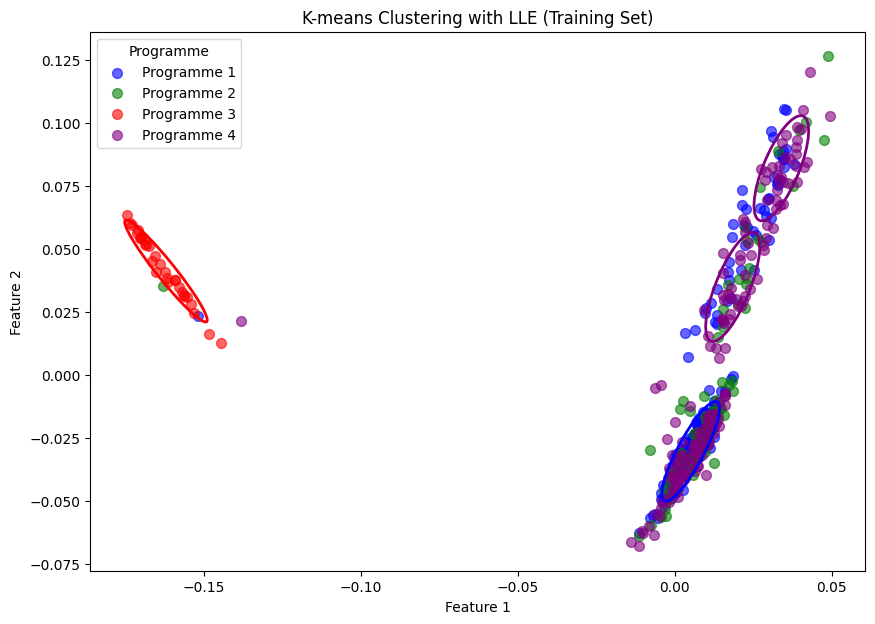

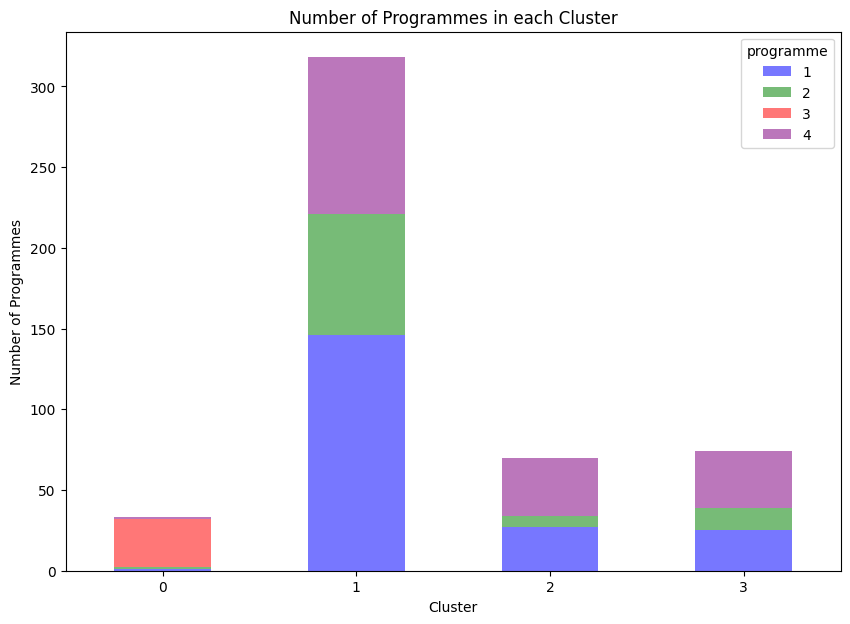

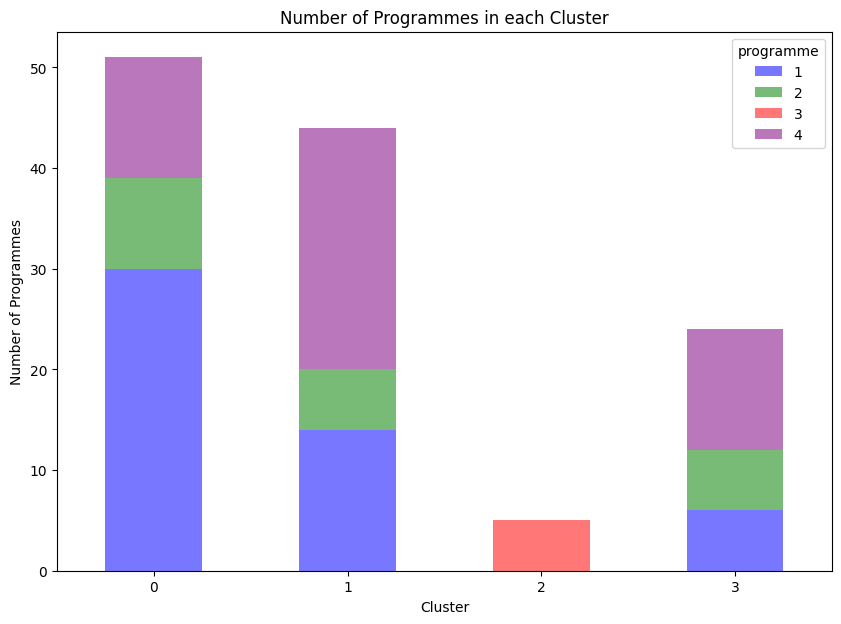

Adjusted Rand Index for the test set: 0.1057421675356741


In [19]:
import pandas as pd
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, programme

def apply_lle(data, n_components=2, n_neighbors=10, random_state=42):
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state, method='standard')
    return lle.fit_transform(data)

def apply_kmeans(data, n_clusters=4, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(data)
    return kmeans, labels
def plot_results_with_ellipses(data_isomap, labels, programme, title):
    cmap = ListedColormap(['blue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 7))
    color_map = {1: 'blue', 2: 'green', 3: 'red', 4: 'purple'}
    class_labels = ['Programme 1', 'Programme 2', 'Programme 3', 'Programme 4']

    # Scatter plot
    for i, color in zip(range(1, 5), ['blue', 'green', 'red', 'purple']):
        idx = programme == i
        plt.scatter(data_isomap[idx, 0], data_isomap[idx, 1], color=color, s=50, alpha=0.6, label=class_labels[i-1])

    plt.legend(title='Programme')
    plt.title(title)
    plt.xlabel('Feature 1')  # Adjust label as per your feature
    plt.ylabel('Feature 2')  # Adjust label as per your feature

    # Draw ellipses
    for label in np.unique(labels):
        cluster_points = data_isomap[labels == label]
        programme_cluster = programme[labels == label]
        if cluster_points.size == 0:
            continue

        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:, 0]
        theta = np.degrees(np.arctan2(vy, vx))
        width, height = 3 * np.sqrt(eigenvalues)  # 3 standard deviations to make ellipses larger

        # Determine the color by voting
        unique, counts = np.unique(programme_cluster, return_counts=True)
        most_frequent = unique[np.argmax(counts)]
        ellipse_color = color_map[most_frequent]

        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=ellipse_color, lw=2, facecolor='none')
        plt.gca().add_patch(ellipse)

    plt.show()

def compute_cluster_programme_counts(data, labels, programme):
    df = pd.DataFrame({'labels': labels, 'programme': programme})
    return pd.crosstab(df['labels'], df['programme'])

def plot_cluster_programme_bar(cluster_counts):
    colors = ['#0000FF88', '#00800088', '#FF000088', '#80008088']
    ax = cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 7), color=colors)
    plt.title('Number of Programmes in each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Programmes')
    plt.xticks(rotation=0)
    plt.show()

def main():
    file_path = 'CW_Data.xlsx'
    data_scaled, programme = load_and_preprocess_data(file_path)

    # Split the data into training and testing sets and apply LLE
    train_data, test_data, train_programme, test_programme = train_test_split(data_scaled, programme, test_size=0.2, random_state=42)
    train_data = apply_lle(train_data)
    test_data = apply_lle(test_data)

    # Apply K-means to the training data
    kmeans_train, train_labels = apply_kmeans(train_data)
    kmeans_test, test_labels = apply_kmeans(test_data)

    # Plot clustering results for the training set
    plot_results_with_ellipses(train_data, train_labels, train_programme, 'K-means Clustering with LLE (Training Set)')

    # Compute and plot the number of programmes in each cluster for the training and test sets
    train_cluster_counts = compute_cluster_programme_counts(train_data, train_labels, train_programme)
    plot_cluster_programme_bar(train_cluster_counts)
    test_cluster_counts = compute_cluster_programme_counts(test_data, test_labels, test_programme)
    plot_cluster_programme_bar(test_cluster_counts)

    # Calculate and print the Adjusted Rand Index for the test set
    test_ari = adjusted_rand_score(test_programme, test_labels)
    print(f"Adjusted Rand Index for the test set: {test_ari}")

if __name__ == "__main__":
    main()


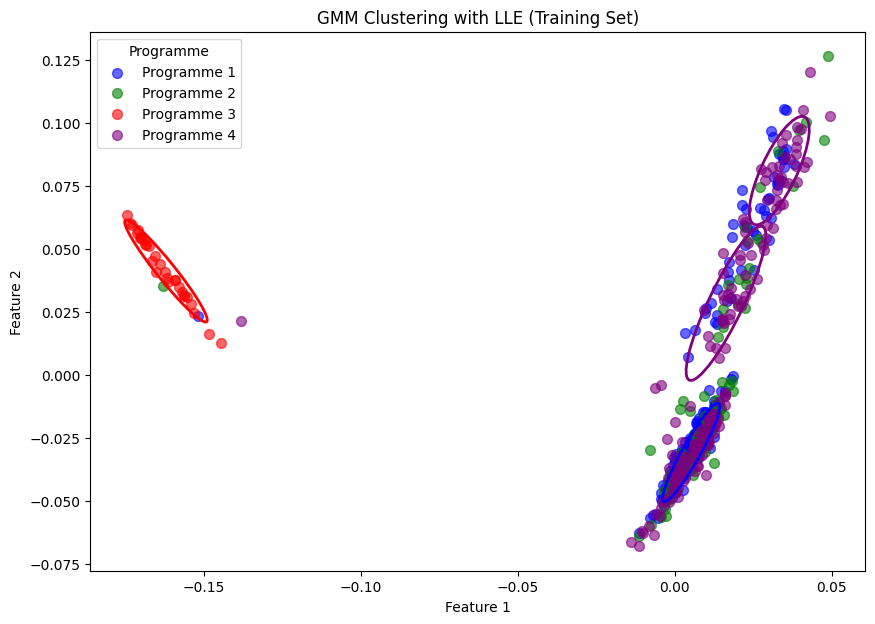

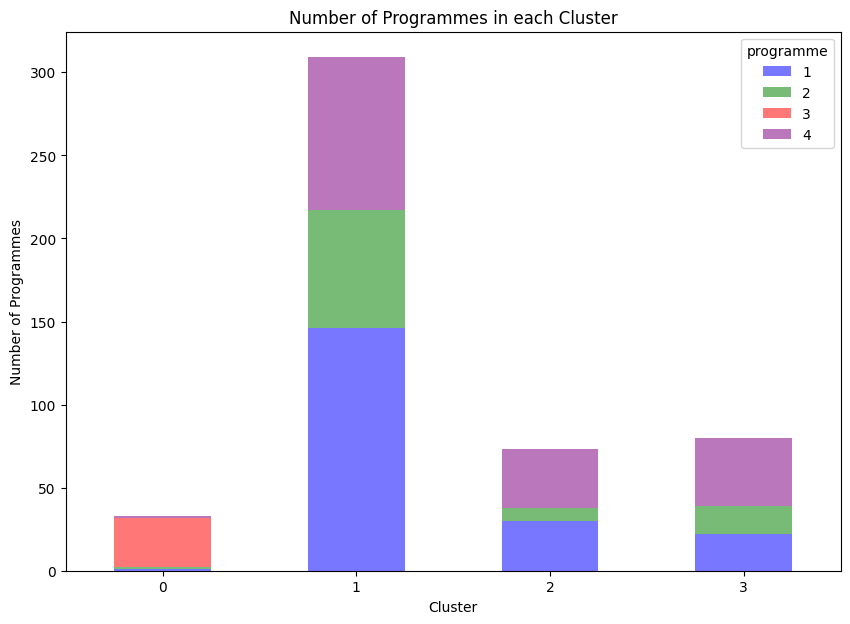

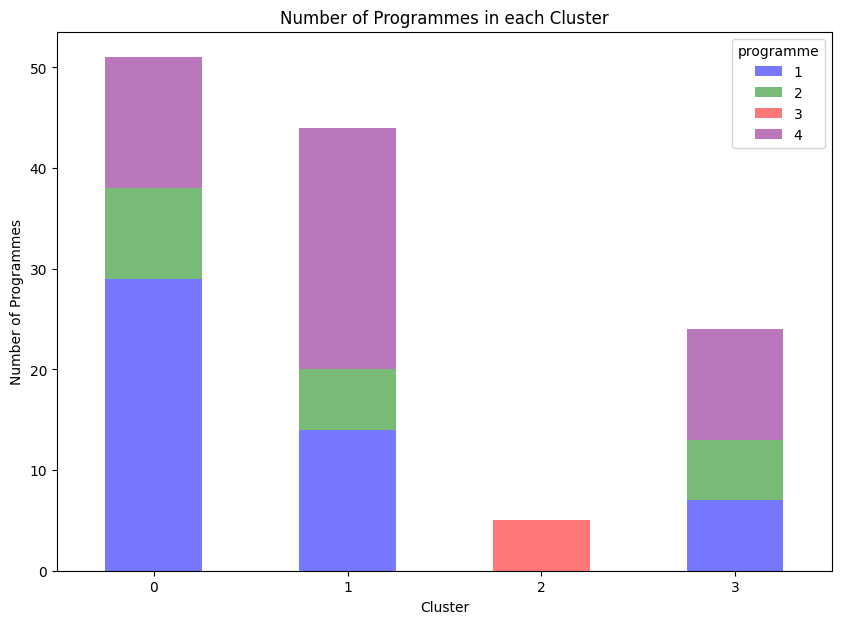

Adjusted Rand Index for the test set: 0.09275624521606012


In [26]:
import pandas as pd
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    programme = data.pop('Programme').values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, programme

def apply_lle(data, n_components=2, n_neighbors=10, random_state=42):
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state, method='standard')
    return lle.fit_transform(data)

def apply_gmm(data, n_components=4, covariance_type='full', random_state=42):
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=random_state)
    gmm.fit(data)
    labels = gmm.predict(data)
    return gmm, labels

def plot_results_with_ellipses(data_isomap, labels, programme, title):
    cmap = ListedColormap(['blue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 7))
    color_map = {1: 'blue', 2: 'green', 3: 'red', 4: 'purple'}
    class_labels = ['Programme 1', 'Programme 2', 'Programme 3', 'Programme 4']

    for i, color in zip(range(1, 5), ['blue', 'green', 'red', 'purple']):
        idx = programme == i
        plt.scatter(data_isomap[idx, 0], data_isomap[idx, 1], color=color, s=50, alpha=0.6, label=class_labels[i-1])

    plt.legend(title='Programme')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    for label in np.unique(labels):
        cluster_points = data_isomap[labels == label]
        programme_cluster = programme[labels == label]
        if cluster_points.size == 0:
            continue

        mean = np.mean(cluster_points, axis=0)
        cov = np.cov(cluster_points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:, 0]
        theta = np.degrees(np.arctan2(vy, vx))
        width, height = 3 * np.sqrt(eigenvalues)

        unique, counts = np.unique(programme_cluster, return_counts=True)
        most_frequent = unique[np.argmax(counts)]
        ellipse_color = color_map[most_frequent]

        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=ellipse_color, lw=2, facecolor='none')
        plt.gca().add_patch(ellipse)

    plt.show()

def compute_cluster_programme_counts(data, labels, programme):
    df = pd.DataFrame({'labels': labels, 'programme': programme})
    return pd.crosstab(df['labels'], df['programme'])

def plot_cluster_programme_bar(cluster_counts):
    colors = ['#0000FF88', '#00800088', '#FF000088', '#80008088']
    ax = cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 7), color=colors)
    plt.title('Number of Programmes in each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Programmes')
    plt.xticks(rotation=0)
    plt.show()

def main():
    file_path = 'CW_Data.xlsx'
    data_scaled, programme = load_and_preprocess_data(file_path)

    train_data, test_data, train_programme, test_programme = train_test_split(data_scaled, programme, test_size=0.2, random_state=42)
    train_data = apply_lle(train_data)
    test_data = apply_lle(test_data)

    gmm_train, train_labels = apply_gmm(train_data)
    gmm_test, test_labels = apply_gmm(test_data)

    plot_results_with_ellipses(train_data, train_labels, train_programme, 'GMM Clustering with LLE (Training Set)')

    train_cluster_counts = compute_cluster_programme_counts(train_data, train_labels, train_programme)
    plot_cluster_programme_bar(train_cluster_counts)
    test_cluster_counts = compute_cluster_programme_counts(test_data, test_labels, test_programme)
    plot_cluster_programme_bar(test_cluster_counts)

    test_ari = adjusted_rand_score(test_programme, test_labels)
    print(f"Adjusted Rand Index for the test set: {test_ari}")

if __name__ == "__main__":
    main()
